In [2]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt


# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
### default kütüphaneler, data management için paketler, görüntü işleme ve visualization için kütüphaneler
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import os

#sklearn paketleri
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#tensorflow paketleri
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D,
                                    BatchNormalization, Flatten,
                                    GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

2024-11-22 23:48:11.685637: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732290491.697435 1045592 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732290491.701160 1045592 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 23:48:11.716149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# le = LabelEncoder()
# images = []
# labels = []
# #'data/raw/character_set1/training_data/'
# training_paths = ['data/raw/character_set1/dataset/']
# #testing_path = 'data/raw/character_set1/testing_data/'
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]


In [4]:
# for training_path in training_paths:
#     dir_list = os.listdir(training_path)
#     for i in dir_list:
#       dir = os.path.join(training_path, i)
#       file_list = os.listdir(dir)
#       for j in file_list:
#         files = os.path.join(dir, j)
#         img = cv2.imread(files)
#         img = cv2.resize(img, (64,64))
#         img = np.expand_dims(img, axis=-1)
#         img = np.array(img, dtype=np.float32)
#         img = img/255
#         images.append(img)
#         labels.append(i)
IMG_SHAPE = (64, 64)
IMG_SIZE = (64, 64, 3)
BATCH_SIZE = 64
opt = Adam(learning_rate = 0.00001, epsilon = 1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10
main_path = 'data/raw/character_set3'
df = directory_to_df(main_path)

df.head()
df['label'].value_counts()

I0000 00:00:1732290494.233132 1045592 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4056 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:08:00.0, compute capability: 7.5


The number of samples found: 85199


label
e    3284
r    3284
n    3281
a    3281
m    3281
q    3279
u    3278
i    3277
d    3277
s    3276
x    3276
l    3276
k    3276
y    3276
t    3276
g    3275
p    3275
o    3275
f    3275
h    3275
w    3275
z    3275
v    3274
c    3274
b    3274
j    3274
Name: count, dtype: int64

## Print out details of X and y

In [5]:
# X = np.array(images)
# print("len(X): ",len(X))
# print("X.shape: ", X.shape)

# y = np.array(labels)
# print("len(y): ",len(y))
# print("y.shape: ", y.shape)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = 0.30,
                                                   random_state = 41)
training_df = pd.concat((X_train, y_train), axis = 1)
testing_df = pd.concat((X_test, y_test), axis = 1)

X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


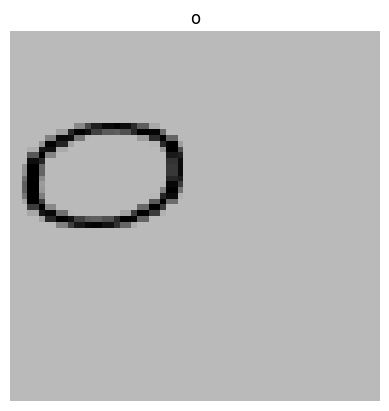

The shape of the image: (64, 64, 3)


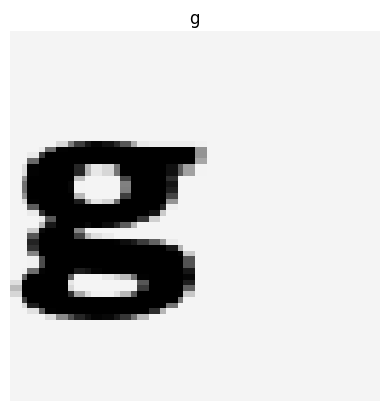

The shape of the image: (64, 64, 3)


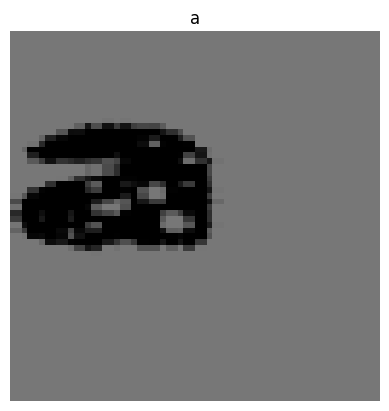

The shape of the image: (64, 64, 3)


In [6]:
# le = LabelEncoder()
# y = le.fit_transform(y)
# X_sh, y_sh = shuffle(X, y, random_state=42)
gen = ImageDataGenerator(dtype = np.int32, brightness_range = [0.0, 1.0],
                         fill_mode = 'nearest')
gen2 = ImageDataGenerator(dtype = np.int32, fill_mode = 'nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col = 'image', y_col = 'label',
                                   batch_size = BATCH_SIZE,
                                   target_size = IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col = 'image', y_col = 'label',
                                    batch_size = BATCH_SIZE,
                                    target_size = IMG_SHAPE,
                                    shuffle = False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col = 'image', y_col = 'label',
                                   batch_size = BATCH_SIZE,
                                   target_size = IMG_SHAPE,
                                   shuffle = False)
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))
BATCH_NUM = 10
IMG_NUM = 2
show_image(train_gen[BATCH_NUM][0][IMG_NUM], 
           mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print("The shape of the image:", train_gen[BATCH_NUM][0][IMG_NUM].shape)
BATCH_NUM = 31
IMG_NUM = 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM], 
           mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print("The shape of the image:", train_gen[BATCH_NUM][0][IMG_NUM].shape)
BATCH_NUM = 65
IMG_NUM = 30
show_image(train_gen[BATCH_NUM][0][IMG_NUM], 
           mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print("The shape of the image:", train_gen[BATCH_NUM][0][IMG_NUM].shape)

In [7]:
# # Split the data: 80% training, 20% testing
# X_train, X_test, y_train, y_test = train_test_split(
#     X_sh, y_sh, test_size=0.2, random_state=42, stratify=y_sh
# )

# print("Training samples:", len(X_train))
# print("Testing samples:", len(X_test))

# Create Keras model
create a neural network model

In [8]:
# model = Sequential([
#     Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(64,64,3)),
#     MaxPooling2D(),
#     Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
#     MaxPooling2D(),
#     Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
#     MaxPooling2D(),
#     Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
#     MaxPooling2D(),
#     Flatten(),
#     Dense(units=128, activation='relu'),
#     Dense(units=64, activation='relu'),
#     Dense(units=len(le.classes_), activation='sigmoid')  # Dynamic output units
# ])
#custom cnn algoritması
# IMG_SIZE = (64,64)
# BATCH_SIZE = 64
CNN_model = Sequential()
CNN_model.add(Input(shape=(64, 64, 3), batch_size = 64, name = 'Input')) #giriş katmanı
CNN_model.add(Conv2D(3, (3, 3), strides = 1, activation = 'relu', padding = 'same')) #ilk katman
CNN_model.add(Conv2D(128, (3, 3), activation = 'relu')) #ikinci katman
CNN_model.add(MaxPool2D((3, 3))) #max pooling katmanı
CNN_model.add(Conv2D(256, (3, 3), activation = 'relu')) #üçüncü katman
CNN_model.add(Dropout(0.2)) #overfittingi engellemek için nöronların yüzde 20sini safdışı bırakıyoruz
CNN_model.add(Conv2D(256, (3, 3), strides = 2, activation = 'relu', padding = 'same')) #strides değeri 2 yapılarak görüntü boyutu yarıya indiriliyor
CNN_model.add(MaxPool2D((2, 2))) #ikinci max pooling katmanı
CNN_model.add(Conv2D(512, (3, 3), activation = 'relu', padding = 'same')) #beşinci katman
CNN_model.add(Dropout(0.2)) #overfittingi engellemek için nöronların yüzde 20sini safdışı bırakıyoruz
CNN_model.add(Conv2D(1024, (2, 2), activation = 'relu', padding = 'same')) #altıncı katman
CNN_model.add(MaxPool2D(2, 2)) #son max pooling katmanı
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation = 'selu'))
CNN_model.add(Dense(len(mapping), activation = 'softmax'))
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (64, 64, 64, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (64, 62, 62, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (64, 20, 20, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (64, 18, 18, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 18, 18, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (64, 9, 9, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (64, 4, 4, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (64, 4, 4, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 4, 4, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (64, 4, 4, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (64, 2, 2, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (64, 4096)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1024)             │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (64, 26)               │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,389,230 (32.00 MB)

 Trainable params: 8,389,230 (32.00 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
CNN_model.compile(optimizer = Adam(), loss = loss, metrics = ['accuracy'])

Epoch 1/20


/home/dangazelle/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732290497.226898 1045856 service.cc:148] XLA service 0x7f66240023a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732290497.227238 1045856 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-11-22 23:48:17.280736: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732290497.480286 1045856 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-22 23:48:17.944995: I external/local_xla/

  5/699 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.0396 - loss: 18.0777

I0000 00:00:1732290502.334363 1045856 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


688/699 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4789 - loss: 2.4170

2024-11-22 23:48:46.619453: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[57,128,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[57,3,64,64]{3,2,1,0}, f32[128,3,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-22 23:48:46.669741: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[57,256,18,18]{3,2,1,0}, u8[0]{0}) custom-call(f32[57,128,20,20]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4827 - loss: 2.3966

2024-11-22 23:48:51.274567: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,128,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,64,64]{3,2,1,0}, f32[128,3,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-22 23:48:51.314511: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,256,18,18]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,20,20]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend


Epoch 1: val_loss improved from inf to 0.31911, saving model to CustomCNN_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.4831 - loss: 2.3948 - val_accuracy: 0.9199 - val_loss: 0.3191 - learning_rate: 0.0010
Epoch 2/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9056 - loss: 0.3415
Epoch 2: val_loss improved from 0.31911 to 0.22639, saving model to CustomCNN_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.9056 - loss: 0.3415 - val_accuracy: 0.9419 - val_loss: 0.2264 - learning_rate: 0.0010
Epoch 3/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9330 - loss: 0.2385
Epoch 3: val_loss improved from 0.22639 to 0.21805, saving model to CustomCNN_model.keras
699/699 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.9330 - loss: 0.2385 - val_accuracy: 0.9487 - val_loss: 0.2181 - learning_rate: 0.0010
Epoch 4/20
699/699 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9410 - loss: 0.2043
Epoch 4: val_loss improved from 0.21805 to 

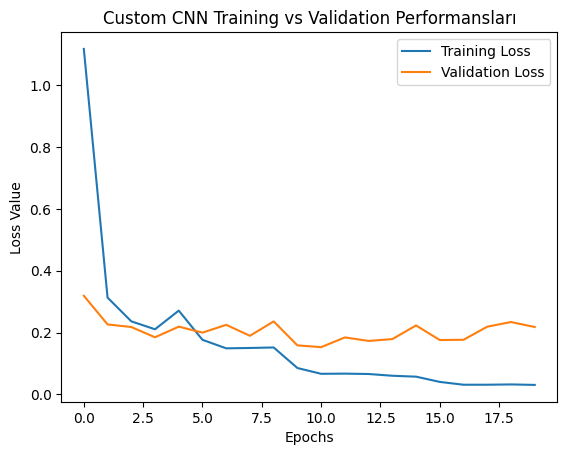

395/400 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2024-11-22 23:57:32.456977: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[24,128,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,3,64,64]{3,2,1,0}, f32[128,3,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-22 23:57:32.496290: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[24,256,18,18]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,128,20,20]{3,2,1,0}, f32[256,128,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

400/400 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
		The Custom CNN Eğitim Performansı
              precision    recall  f1-score   support

           a       0.98      0.96      0.97       982
           b       0.96      0.99      0.98      1046
           c       0.97      0.99      0.98       967
           d       0.99      0.98      0.98       951
           e       0.98      0.96      0.97       987
           f       0.98      0.98      0.98       927
           g       0.99      0.95      0.97      1011
           h       0.97      0.98      0.97      1004
           i       0.96      0.97      0.97      1014
           j       0.98      0.97      0.98      1002
           k       0.97      0.98      0.98      1001
           l       0.96      0.97      0.96       949
           m       0.98      0.98      0.98       932
           n       0.96      0.96      0.96       974
           o       0.95      0.98      0.97      1001
           p       0.98      0.98      0.98       981
   

In [10]:
# history = model.fit(X_sh, y_sh ,validation_split=0.2, batch_size=64, epochs=10)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.legend(['loss', 'val_loss'])
# plt.show()
history = CNN_model.fit(train_gen, epochs = 20, validation_data = valid_gen, callbacks = clbck("CustomCNN"))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title("Custom CNN Training vs Validation Performansları")
plt.show()
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x], test_gen.classes))
print('\t\tThe Custom CNN Eğitim Performansı')
print(classification_report(y_test, pred))

In [11]:
# # Evaluate the model on the testing set
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

# # Evaluate the model on the testing set
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

# print(le.classes_)

# # Separate Evaluation for Uppercase and Lowercase Characters

# # Determine the number of uppercase letters
# # This assumes that the first 'num_uppercase' classes are uppercase letters
# # Adjust 'num_uppercase' based on your actual label encoding
# # num_uppercase = 26  # Typically, A-Z
# # print(f'y_test_len: {len(y_test)}')

# # # Find indices for uppercase and lowercase characters
# # uppercase_indices = np.where(y_test < num_uppercase)
# # lowercase_indices = np.where(y_test >= num_uppercase)

# # # Evaluate the model on uppercase characters
# # test_loss_upper, test_acc_upper = model.evaluate(X_test[uppercase_indices], y_test[uppercase_indices], verbose=0)
# # print(f"Uppercase Test Loss: {test_loss_upper:.4f}")
# # print(f"Uppercase Test Accuracy: {test_acc_upper:.4f}")

# # # Evaluate the model on lowercase characters
# # test_loss_lower, test_acc_lower = model.evaluate(X_test[lowercase_indices], y_test[lowercase_indices], verbose=0)
# # print(f"Lowercase Test Loss: {test_loss_lower:.4f}")
# # print(f"Lowercase Test Accuracy: {test_acc_lower:.4f}")



In [12]:
# # Plot training & validation loss values
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss Over Epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.show()

# # Plot training & validation accuracy values
# plt.figure(figsize=(10, 5))
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy Over Epochs')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()


## Visualization

### Visualize Regions

In [13]:
def visualize_regions(image, regions):
    debug_image = image.copy()
    for (x, y, w, h) in regions:
        cv2.rectangle(debug_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.imshow("Detected Text Regions", debug_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### Visualize Processed Image

In [14]:
def display_processed_image(window_name, processed_image):
    cv2.imshow(window_name, processed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Image Processing Operations

In [15]:
def image_processing_operations_visualization(image, operation):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if operation == 'threshold':
        # Apply thresholding to get a binary image
        _, processed_image = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        window_name = "Thresholded Image"

    elif operation == 'erosion':
        # Apply thresholding and then erosion
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((2, 1), np.uint8)
        processed_image = cv2.erode(thresh, kernel, iterations=1)
        window_name = "Eroded Image"

    elif operation == 'dilation':
        # Apply thresholding and then dilation
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((1, 1), np.uint8)
        processed_image = cv2.dilate(thresh, kernel, iterations=1)
        window_name = "Dilated Image"

    else:
        raise ValueError("Operation must be 'threshold', 'erosion', or 'dilation'")

    # Display the processed image
    display_processed_image(window_name, processed_image)
    
    return _, processed_image

## Italic Characters Detection

### Compute Skew Angle

In [16]:
def compute_skew_angle(region):
    # Use moments to calculate the skew angle of a text region
    coords = np.column_stack(np.where(region > 0))
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    return angle

### Deskew Angle

In [17]:
def deskew_region(region, angle):
    # Rotate the region by the computed angle
    (h, w) = region.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(region, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=255)
    return rotated

## Detect Text Regions

In [18]:
def detect_text_regions(image):
    # Apply image processing operation (e.g., thresholding, erosion, or dilation)
    _, processed_image = image_processing_operations_visualization(image, 'dilation')
    
    # Find contours (regions of characters)
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # region = processed_image[y:y+h, x:x+w]
        
        # Compute the skew angle of the detected region
        # angle = compute_skew_angle(region)
        
        # Deskew the region if the skew angle is significant
        # if abs(angle) > 5:  # Adjust the threshold based on your needs
        #     region = deskew_region(region, angle)
        
        # Update bounding box after deskewing (if any change occurred)
        # if abs(angle) > 5:
        #     x, y, w, h = cv2.boundingRect(region)'''
        
        # old
        # regions.append((x-1, y, w+1, h))
        
        # new
        if 0 < w < 100 and 0 < h < 100:  # Size filter
            regions.append((x, y, w, h))
    
    # Visualize the image regions
    visualize_regions(image, regions)
    
    return regions

## Sorting Bounding Boxes by Rows and Columns

In [19]:
def sort_bounding_boxes(regions):
    # Sort by `y` first (top-to-bottom) with a threshold to group by rows
    row_threshold = 20  # Adjust based on character spacing
    regions = sorted(regions, key=lambda box: box[1])

    # Group bounding boxes into rows
    rows = []
    current_row = [regions[0]]
    
    for i in range(1, len(regions)):
        if abs(regions[i][1] - current_row[-1][1]) < row_threshold:
            current_row.append(regions[i])
        else:
            rows.append(current_row)
            current_row = [regions[i]]
    rows.append(current_row)
    
    # Sort each row left-to-right
    sorted_regions = []
    for row in rows:
        sorted_row = sorted(row, key=lambda box: box[0])
        sorted_regions.extend(sorted_row)
    
    return sorted_regions


## Resize Image Operation

In [20]:
def resize_image(image, target_size=(64, 64), mode='normal'):
    if mode == 'normal':
        # Normal resize (ignores aspect ratio)
        resized_image = cv2.resize(image, target_size)
    elif mode == 'aspect_ratio':
        # Resize while maintaining aspect ratio
        (iH, iW) = image.shape[:2]
        if iW > iH:
            resized_image = cv2.resize(image, (target_size[0], int(target_size[0] * iH / iW)))
        else:
            resized_image = cv2.resize(image, (int(target_size[1] * iW / iH), target_size[1]))
        
        # After resizing, padding the image to make it exactly target_size
        (iH, iW) = resized_image.shape
        dX = int(max(0, target_size[0] - iW) / 2.0)
        dY = int(max(0, target_size[1] - iH) / 2.0)
        resized_image = cv2.copyMakeBorder(resized_image, dY, dY, dX, dX, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    else:
        raise ValueError("Mode must be either 'normal' or 'aspect_ratio'")
    
    return resized_image

## Recognize Characters

In [25]:
def recognize_characters(image, CNN_model, label_encoder):
    regions = detect_text_regions(image)
    
    sorted_regions = sort_bounding_boxes(regions)
    # print(sorted_regions)

    characters = []
    for (x, y, w, h) in sorted_regions:
        char_image = image[y:y+h, x:x+w]
        
        # Add padding
        pad = 1
        char_image = cv2.copyMakeBorder(char_image, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        
        # Check if the char_image is empty
        if char_image.size == 0:
            print(f"Skipping empty character region at ({x}, {y}, {w}, {h})")
            continue  # Skip this iteration if the character image is empty
        
        # Print the shape of the character image for debugging
        print(f"Character image shape: {char_image.shape}")
        
        # Resize the character image
        char_image_resized = resize_image(char_image, target_size=(64, 64), mode='normal')
        char_image_normalized = char_image_resized / 255.0

        # cv2.imshow('image after resized',char_image_normalized)
        # cv2.waitKey(0)  # Wait indefinitely for a key press
        # cv2.destroyAllWindows() 
        
        prediction = CNN_model.predict(np.expand_dims(char_image_normalized, axis=0))
        predicted_class = np.argmax(prediction, axis=1)

        if predicted_class[0] not in range(len(label_encoder.classes_)):
            print(f"Unrecognized label: {predicted_class[0]}")
            predicted_char = "?"  # Placeholder for unrecognized labels
        else:
            predicted_char = label_encoder.inverse_transform(predicted_class)[0]
        
        #To be decided later #If the current character is 'i' or 'j' we will
        #pop the last element out (which is supposed to be the dot above small i and j)

        # ----- UNCOMMENT LATER -----
        # if predicted_char == 'i' or predicted_char == 'j'
        #     characters.pop()
        
        characters.append(predicted_char)

    return characters

# Driver Code

In [35]:
from sklearn.preprocessing import LabelEncoder
imggg = 'data/raw/character_set1/Test_2.png'
image = cv2.imread(imggg) 
# Encode the labels using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_pred = recognize_characters(image, CNN_model, label_encoder)
# characters = [chr(value) for value in y_pred]
print(y_pred)
print(len(y_pred))

Character image shape: (42, 36, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Character image shape: (42, 24, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Character image shape: (29, 27, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Character image shape: (28, 45, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Character image shape: (29, 29, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Character image shape: (29, 29, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Character image shape: (42, 27, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Character image shape: (29, 42, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Character image shape: (29, 26, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Character image shape: (29, 25, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Character image shape: (15, 8, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Character image shape: (29, 20, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Character image shape: (28, 45, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Character image shape: (8, 8, 3)
1/1 ━━━━━━━━━━━━━━━